## Imports and Plot Config

In [329]:
%load_ext autoreload
%autoreload 2

# file system
import os

# data
import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

# widgets
import ipywidgets.widgets as widgets
from ipywidgets import interact, fixed
from IPython.display import display

# plotting
## matplotlib
import jupyterthemes as jt
import matplotlib.dates as pltdates
import matplotlib.pyplot as plt
## plotly
import plotly.offline as po
import plotly.express as px
## seaborn
import seaborn as sns

# nem data
from src.data import merge_mappings
from src.plot_helpers import matplotlib_helpers
from src.visualization.generic_plots import plot_value_by_element
from src.visualization.generic_plots import find_nonzero_category
from src.visualization.generic_plots import plot_nonzero_elements_by_category
from src.visualization.generic_plots import stacked_bar_subplots
from src.visualization.generic_plots import nofb_plot, nofb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
# Jupyter themes styling
jt.jtplot.style(context='paper', theme='grade3')
# Matplotlib interactive notebook figures
%matplotlib widget
# Plotly offline notebook mode
po.init_notebook_mode()

# Matplotlib plot config
plt_cat_cmap = plt.cm.tab20b
plt_seq_cmap = plt.cm.gnuplot
plt_div_cmap = plt.cm.Spectral
dt_fmt = pltdates.DateFormatter('%d/%m/%y')

In [133]:
# dask progress
ProgressBar().register()

## Directories and Mapping Files

In [134]:
data_dir = os.path.join(os.pardir, 'data')
raw_dir = os.path.join(data_dir, 'raw')
proc_dir = os.path.join(data_dir, 'processed')
ext_dir = os.path.join(data_dir, 'external')
nemweb_dir = os.path.join(raw_dir, 'nemweb_data')

dispatch_dir = os.path.join('/mnt', 'DATADRIVE2', 'DISPATCHLOAD')
causer_pays_dir = os.path.join('/mnt', 'DATADRIVE2', 'FCAS Data',
                               '202003', 'parquet')
five_min_cp_dir = os.path.join(raw_dir, 'five_main_cp_factors',
                               'Five_Min_Factors_1_March_2020_to_29_March_2020')

In [135]:
cp_elements = pd.read_csv(os.path.join(raw_dir, 'elements_causpays_mapping.csv'))
cp_variables = pd.read_csv(os.path.join(raw_dir, 'variables_causpays_mapping.csv'))
gen_loads = pd.read_csv(os.path.join(proc_dir, 'cleaned_gen_loads.csv'))
ems_duid = pd.read_csv(os.path.join(ext_dir, 'emsname_duid.csv'))
ems_duid_region = pd.read_csv(os.path.join(proc_dir, 'emsname_duid_region.csv'))

## Dispatch Data

In [136]:
dispatch_df = os.path.join(dispatch_dir, 'PUBLIC_DVD_DISPATCHLOAD_202003010000.parquet')
dispatch_df = pd.read_parquet(dispatch_df)
dispatch_df['SETTLEMENTDATE'] = dispatch_df['SETTLEMENTDATE'].astype(np.datetime64)
dispatch_df = dispatch_df.set_index('SETTLEMENTDATE')

## Global Variables

In [137]:
area_region_map = {'NSW1': 'Mainland', 'SA1': 'Mainland', 'VIC1': 'Mainland',
                   'QLD1': 'Mainland', 'TAS1': 'Tasmania'}
cp_factors = ['LEF', 'LNEF', 'REF', 'RNEF']

## Five Minute Factor Data

### Load Five Minute Factor Data for March 2020

This data contains aggregated five minute LNEF, LEF, RNEF, REF factors for each DUID for the month of March 2020
- **LNEF**: Lower Required but Unit not Enabled for Frequency Regulation
- **LEF**: Lower Required and Unit enabled for Frequency Regulation
- **RNEF**: Raise Required but Unit enabled for Frequency Regulation
- **REF**: Raise Required and Unit enabled for Frequency Regulation

In [375]:
five_min_cp_files = [file for file in os.listdir(five_min_cp_dir) if '.csv' in file]
five_min_cp = pd.DataFrame()
for file in five_min_cp_files:
    df = pd.read_csv(os.path.join(five_min_cp_dir, file))
    five_min_cp = pd.concat([five_min_cp, df])
five_min_cp['DTIME'] = pd.to_datetime(five_min_cp['DTIME'])
five_min_cp = five_min_cp.sort_values('DTIME')
del(df)

In [376]:
print(f'Five Minute Factors begin at {five_min_cp.iloc[0,0]} and end at {five_min_cp.iloc[-1,0]}')

Five Minute Factors begin at 2020-03-01 00:00:00 and end at 2020-03-29 00:00:00


### Find Dispatch Intervals excluded from Contribution Factor calculations

Will be used to verify if these intervals have been included or excluded from Causer Pays data

In [377]:
start = five_min_cp.iloc[0]["DTIME"]
end = five_min_cp.iloc[-1]["DTIME"]
all_datetime = pd.date_range(start, end, freq='5T')
excluded_di = all_datetime.difference(five_min_cp['DTIME'])

## Causer Pays data for the Five Minute Factor period of March 2020

#### Load data using Dask
- Compute time for each compute step is ~90 seconds
- Requires at least ~40GB of RAM

In [149]:
read_parquet_str = causer_pays_dir + os.sep + '*.parquet'
df = dd.read_parquet(read_parquet_str, index='datetime')

/home/abi/.local/share/virtualenvs/nem-data-analysis-PJjZKztB/lib/python3.8/site-packages/fastparquet/encoding.py:222: NumbaDeprecationWarning:

The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.

/home/abi/.local/share/virtualenvs/nem-data-analysis-PJjZKztB/lib/python3.8/site-packages/fastparquet/encoding.py:224: NumbaDeprecationWarning:

The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.



#### Check Data Coverage of Mappable Elements using Regulation Participation Factor

Mappable elements are those elements in Causer Pays data that can be mapped to a DUID within the Generators and Scheduled Loads table published by AEMO.
This will determine to what extent the data accurately reperesents system or area-wide values such as FI

In [352]:
reg_rpf_df = df[df['variablenumber'] == 4]
reg_rpf_df = reg_rpf_df.drop(columns=['valuequality', 'variablenumber'])

regulation_coverage = reg_rpf_df[start:end]
regulation_coverage = regulation_coverage.reset_index()
regulation_coverage = regulation_coverage.merge(ems_duid_region,
                                                left_on='elementnumber',
                                                right_on='ELEMENTNUMBER')
regulation_coverage['Area'] = regulation_coverage['Region'].replace(area_region_map)
regulation_coverage = regulation_coverage.groupby(['datetime', 'Area']).sum()
regulation_coverage = regulation_coverage.compute()

[########################################] | 100% Completed |  1min 57.7s
[########################################] | 100% Completed |  1min 57.8s


In [353]:
regulation_coverage = regulation_coverage.unstack('Area')
regulation_coverage = regulation_coverage['fcas_value']

In [357]:
fig, ax = plt.subplots(2, 1, figsize=(6,7), sharex=True)

ax[0].scatter(regulation_coverage.index, regulation_coverage['Mainland'],
              color='b', s=5)
ax[0].set_title('Mainland Sum of RPF% across Mappable Elements - March 2020',
                fontsize=10)
ax[0].set_ylabel('%', fontsize=12)
ax[0] = matplotlib_helpers.y_axis_styling(ax[0], rotation=0)

ax[1].scatter(regulation_coverage.index, regulation_coverage['Tasmania'],
              color='g', s=5)
ax[1].set_title('Tasmania Sum of RPF% across Mappable Elements- March 2020',
                fontsize=10)
ax[1].set_ylabel('%', fontsize=12)
ax[1] = matplotlib_helpers.y_axis_styling(ax[1], rotation=0)
ax[1] = matplotlib_helpers.x_axis_styling(ax[1], rotation=70, fmt=dt_fmt)

plt.tight_layout()

fig.savefig('../reports/figures/regulation_march_2020/reg_par_fac_mar20.png')

<ipython-input-357-765358c95ada>:1: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [153]:
del(regulation_coverage)

#### Determining FI values for the Month

In [154]:
reg_comp_df = df[df['variablenumber'] == 5]
reg_comp_df = reg_comp_df.drop(columns=['valuequality', 'variablenumber'])
reg_comp_df = reg_comp_df[start:end]
reg_comp_df = reg_comp_df.reset_index()

fi_df = reg_comp_df.merge(ems_duid_region, how='left',
                          left_on='elementnumber',
                          right_on='ELEMENTNUMBER')
fi_df['Area'] = fi_df['Region'].replace(area_region_map)
fi_df = fi_df.groupby(['datetime', 'Area']).sum()
fi_df = fi_df.compute()

[########################################] | 100% Completed |  1min 55.9s
[########################################] | 100% Completed |  1min 56.0s


In [155]:
fi_df = fi_df['fcas_value'].unstack('Area')

#### Determining which intervals have been excluded

In [156]:
march_times = fi_df.index.to_series()
march_exclusions = pd.Series(dtype='datetime64[s]')
for di in excluded_di:
    exclusion = (di - pd.Timedelta('5T'), di)
    exclusions = march_times[(march_times > exclusion[0])
                             & (march_times <= exclusion[1])]
    march_exclusions = pd.concat([march_exclusions, exclusions])

In [350]:
fig, ax = plt.subplots(2, 1, figsize=(7,7), sharex=True)


ax[0].scatter(fi_df.index, fi_df['Mainland'],
              color='b', s=5)
ax[0].set_title('Mainland FI across Mappable Elements - March 2020',
                fontsize=10)
ax[0].set_ylabel('MW (Raise >0)', fontsize=12)
ax[0] = matplotlib_helpers.y_axis_styling(ax[0], rotation=0)

ax[1].scatter(fi_df.index, fi_df['Tasmania'],
             color='g', s=5)
ax[1].set_title('Tasmania FI across Mappable Elements - March 2020',
                fontsize=10)
ax[1].set_ylabel('MW (Raise >0)', fontsize=12)
ax[1] = matplotlib_helpers.y_axis_styling(ax[1], rotation=0)

ax[1] = matplotlib_helpers.x_axis_styling(ax[1], rotation=70, fmt=dt_fmt)
plt.tight_layout()
fig.savefig('../reports/figures/regulation_march_2020/fi_mar2020.png')

<ipython-input-350-c17f1cf88d3f>:1: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [180]:
print(f'Number of 4s intervals excluded based on Five Minute Factor data: {len(march_exclusions)}')
print(f'Excluded 4 second intervals comprise of {len(march_exclusions)/len(march_times)*100}% of period')

Excluded 4 second intervals comprise of 4.661095482376303% of period
Number of 4s intervals excluded based on Five Minute Factor data: 28167
Number of 4s intervals excluded from Causer Pays data: 28167


Causer Pays data does not contain excluded intervals

#### Looking at raw values of Area Control Error and ACEI

In [355]:
ace_ace_int = df.query('variablenumber==11 or variablenumber==12 or variablenumber==16')
ace_ace_int = ace_ace_int.compute()
ace_ace_int = ace_ace_int.groupby(['datetime', 'variablenumber']).sum().unstack('variablenumber')
ace_ace_int = ace_ace_int.drop(['elementnumber', 'valuequality'], level=0, axis=1)

[########################################] | 100% Completed | 45.4s
[########################################] | 100% Completed | 45.5s


In [356]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7,9))
ax[0].plot(ace_ace_int.index, ace_ace_int[('fcas_value', 11)],
           label='Area Control Error (ACE)')
ax[0].plot(ace_ace_int.index, ace_ace_int[('fcas_value', 12)],
           label='Low Pass Filter ACE')
ax[0] = matplotlib_helpers.y_axis_styling(ax[0], rotation=0)
ax[0].set_title('ACE and Filtered ACE')

ax[1].plot(ace_ace_int.index, ace_ace_int[('fcas_value', 16)],
           label='ACE Integral (1 hour)')
ax[1].set_title('ACE Integral')
ax[1] = matplotlib_helpers.y_axis_styling(ax[1], rotation=0)
ax[1] = matplotlib_helpers.x_axis_styling(ax[1], rotation=90)
plt.tight_layout()

<ipython-input-356-b222385dd867>:1: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [162]:
del(ace_ace_int)

## High Deviation

### Distribution of FI data and determine appropriate aggregation method

In [163]:
mainland_five_min_fi = fi_df['Mainland'].resample('5T', 
                                                  label='right',
                                                  closed='right')
mainland_five_min_fi_med = mainland_five_min_fi.median()
mainland_five_min_fi_mean = mainland_five_min_fi.mean()

In [164]:
fig, ax = plt.subplots(1, 1)
sns.distplot(fi_df["Mainland"], label='Raw FI (4s)', ax=ax)
sns.distplot(mainland_five_min_fi_med, label='Median FI (5 Min Agg.)', ax=ax)
sns.distplot(mainland_five_min_fi_mean, label='Mean FI (5 Min Agg.)', ax=ax)
ax.set_title('Distribution (KDE) of Mainland Frequency\n'
             + 'and Five Minute Aggregates')
ax.set_xlabel('Mainland FI')
ax.legend()
plt.tight_layout();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Determine High Deviation Periods for Mainland

Since all aggregated factors are scaled by FI, we can use aggregated FI values that approximate actual FI values to find intervals that include large aggregate deviation

Due to differences in order of magnitude (FI ~$10^2$, CP sum of generators in five min interval ~$10^4$) and zero values, both datasets were normalised as follows:
- Five minute aggregate factors (positive or negative) normalised against maximum of absolute values for each factor type 
- Absolute value of FI normalised against maximum of absolute value

This yields an indication of the severity of deviation. 

**Given that the absolute value of FI is used, positive deviations are assisting and negative deviations are hindering**

#### Aggregate mainland five minute factors for each DI

In [165]:
mainland_five_min_cp = five_min_cp.query('CONFIGURATION=="MAINLAND"')

In [166]:
desc_cols = ['COMPONENTID', 'COMPONENTTYPE', 'CONFIGURATION', 'PORTFOLIOID']
mainland_five_min_cp_sum = mainland_five_min_cp.drop(columns=desc_cols)
mainland_five_min_cp_sum = mainland_five_min_cp_sum.groupby('DTIME').sum()

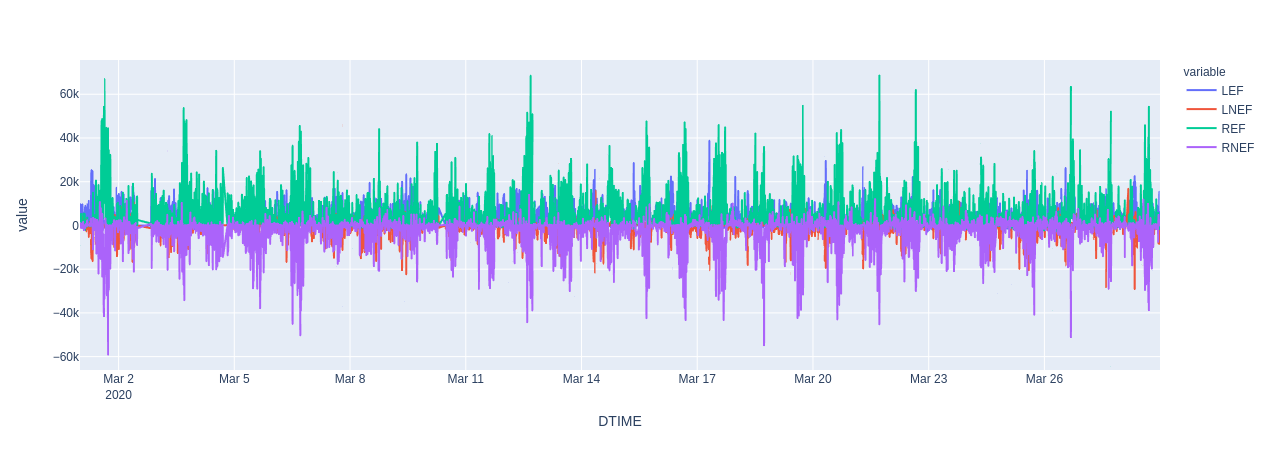

In [167]:
px.line(mainland_five_min_cp_sum.reset_index().melt(id_vars='DTIME'),
        x= 'DTIME', y='value', color='variable')

#### Distribution of aggregated five minute factors, for each factor type

In [168]:
fig, ax = plt.subplots(2, 2)
sns.distplot(mainland_five_min_cp_sum['LEF'], ax=ax[0, 0], color='b')
sns.distplot(mainland_five_min_cp_sum['LNEF'], ax=ax[1, 0], color='g')
sns.distplot(mainland_five_min_cp_sum['REF'], ax=ax[0, 1], color='r')
sns.distplot(mainland_five_min_cp_sum['RNEF'], ax=ax[1, 1], color='m')
for ax in ax:
    for sub_ax in ax:
        sub_ax.set_xlim(-2e4, 2e4)
        sub_ax.set_ylim(0, 6e-4)
        sub_ax = matplotlib_helpers.x_axis_styling(sub_ax)
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

These distribution are for the aggregated (sum) of contribution factors across each five minute dispatch interval.
- As would be expected by the provision of frequency regulation, REF and LEF are positively skewed, i.e. generally positive
    - Higher degree of positive skew of REF probably explained by more frequent need for Regulation Raise
- My expectation of the not-enabled factors is for a fairly symmetrical distribution
    - Expect units to be concerned with complying with dispatch and therefore ramping linearly
    - For many units, there is likely to be deviation around dispatch trajectories and targets
        - Symmetrical if these deviations reflect difficult in conforming to dispatch
        - Positive if units provide PFR - esepcially the case for raise, where units require higher primary energy input
        - Negative if units fail to comply with linear ramp
- LNEF has minor negative skew
- RNEF has distinct negative skew
    - Why is this the case?
    

In [169]:
func_norm_maxabs = lambda x: x/max(abs(x))
norm_mainland_five_min_cp = mainland_five_min_cp_sum.apply(func_norm_maxabs,
                                                           axis=0)
norm_mainland_five_min_cp.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### Normalise absolute values of FI

In [170]:
norm_mainland_fi = (abs(mainland_five_min_fi_med)
                    / max(abs(mainland_five_min_fi_med)))

fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(norm_mainland_fi.index, norm_mainland_fi.values)
ax = matplotlib_helpers.x_axis_styling(ax)
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### Calculate deviations from normalised contribution factors and normalised FI

Normalisation makes it easier to select periods of sustained deviation

In [171]:
deviations = pd.DataFrame(index=norm_mainland_five_min_cp.index)

for col in norm_mainland_five_min_cp.columns:
    deviations[col] = (norm_mainland_five_min_cp[col]
                       / norm_mainland_fi)

# remove 0 FI periods or infinite deviations
deviations = deviations.where(deviations.abs() != np.inf, 0)

In [172]:
ax = deviations[['LNEF', 'RNEF']].plot()
ax.set_ylim(-2e2, 2e2)
# ax = matplotlib_helpers.range_axis_ticks(ax, 'x', 17)
ax = matplotlib_helpers.y_axis_styling(ax, rotation=0)
fig.autofmt_xdate()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Closer Look at Sixth of March

In [182]:
section_start = '2020-03-06 00:00:00'
section_end = '2020-03-7 00:00:00'

In [183]:
section_df = df[section_start:section_end]
section_df = section_df.reset_index()
section_df = section_df.compute()
section_df = merge_mappings.merge_causpays_mappings(section_df, cp_elements,
                                                    cp_variables, ems_duid, gen_loads)

[########################################] | 100% Completed | 43.6s
[########################################] | 100% Completed | 43.7s


In [184]:
section_five_min_cp = mainland_five_min_cp.set_index('DTIME')[section_start:section_end]
section_five_min_cp_sum = mainland_five_min_cp_sum[section_start:section_end]
section_deviations = deviations[section_start:section_end]

In [185]:
section_dispatch = dispatch_df[section_start:section_end]

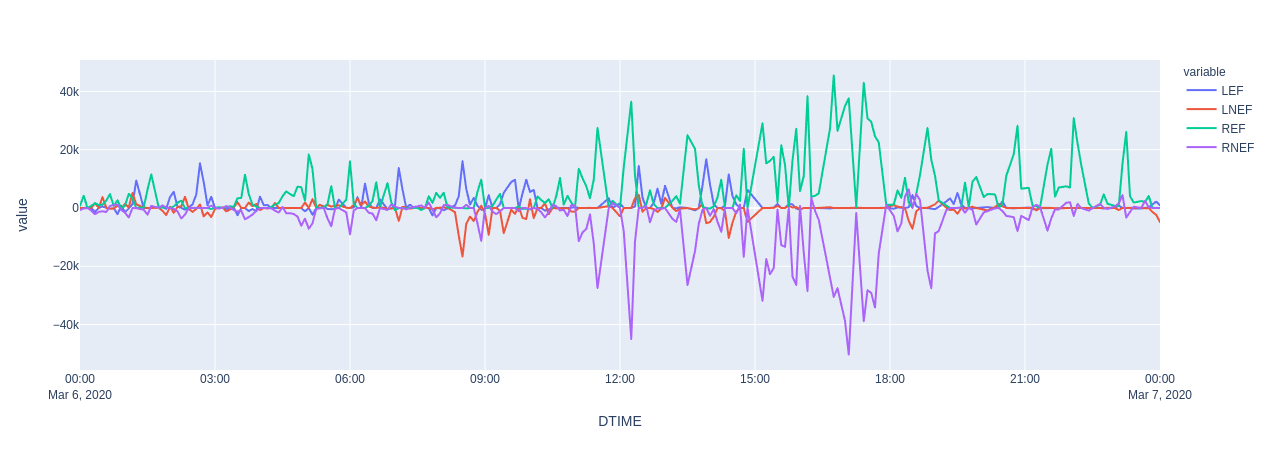

In [186]:
px.line(section_five_min_cp_sum.reset_index().melt(id_vars='DTIME'), x='DTIME', y='value', color='variable')

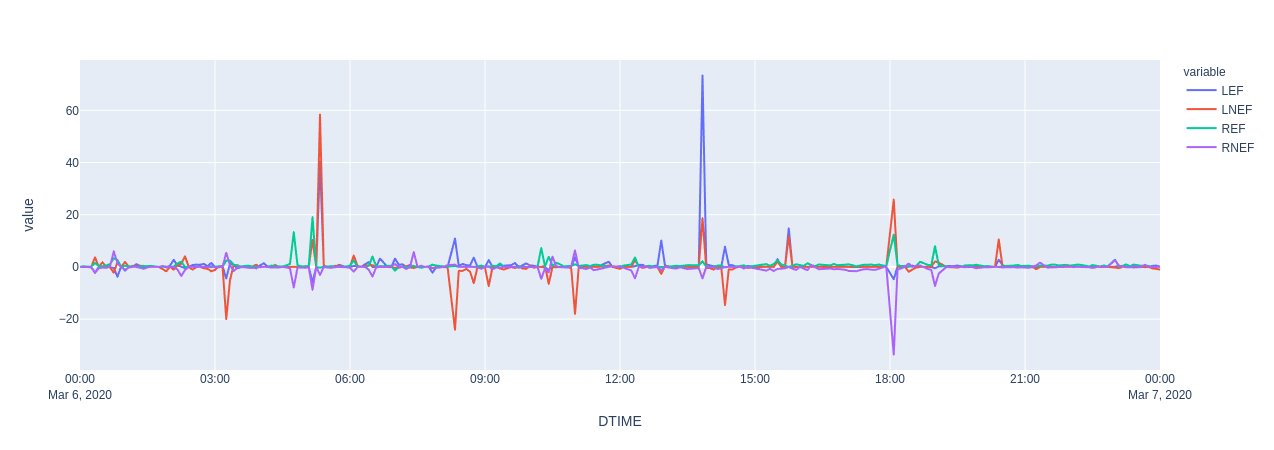

In [187]:
px.line(section_deviations.reset_index().melt(id_vars='DTIME'), x='DTIME', y='value', color='variable')

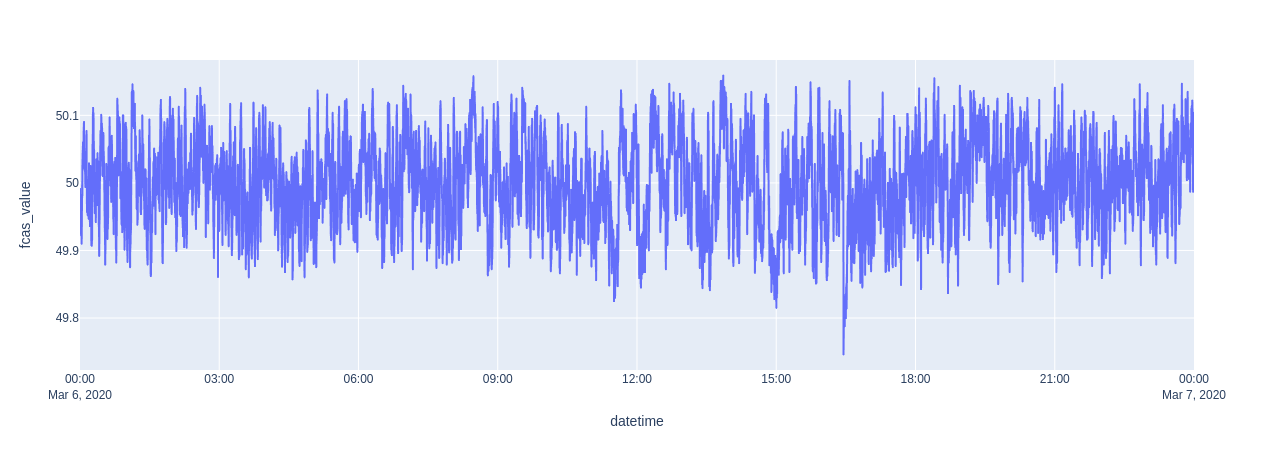

In [188]:
system_freqs = section_df.query('EMSNAME == "FREQ NEM SOUTH"')
px.line(system_freqs, x='datetime', y='fcas_value')

1. DI from 15:40 to 15:50 has high deviation measures in REF (+ve) and RNEF
2. Period from 16:40-18:00 has high RNEF and REF contribution factors and no contingency events

#### High Calculated Deviation Period - 15:35-15:50

In [249]:
period_one_start = '2020-03-06 15:35:00'
period_one_end = '2020-03-06 15:50:00'

period_one_cp = section_five_min_cp[period_one_start:period_one_end]

period_one_df = section_df.set_index('datetime')
period_one_df = period_one_df[period_one_start:period_one_end]

period_one_freq = system_freqs.set_index('datetime')
period_one_freq = period_one_freq[period_one_start:period_one_end]

period_one_fi = fi_df[period_one_start:period_one_end]

In [371]:
period_one_low_rnef = sorted(period_one_cp.sort_values('RNEF').head(10)['COMPONENTID'])
period_one_high_rnef = sorted(period_one_cp.sort_values('RNEF').tail(10)['COMPONENTID'])
period_one_low_lnef = sorted(period_one_cp.sort_values('LNEF').head(10)['COMPONENTID'])
period_one_high_lnef = sorted(period_one_cp.sort_values('LNEF').tail(10)['COMPONENTID'])
period_one_dispatch = section_dispatch[period_one_start:period_one_end]

In [382]:
def lowest_highest_factor_plots(duids, mw_data, dispatch_data, 
                                fi_data, labels, cmap):
    fig, ax = plt.subplots(2, 1, figsize=(9.5,7.5), sharex=True)
    twin_ax = ax[0].twinx()
    twin_ax.plot(fi_data.index, fi_data['Mainland'], 
                 'x-', alpha=0.3, label='FI Value')

    for duid, col in zip(duids, cmap(np.linspace(0, 1, len(duids)))):
        plot_mw = mw_data.query('DUID==@duid').reset_index()
        plot_di = dispatch_data.query('DUID==@duid').reset_index()
        ax[0].plot(plot_mw['datetime'], plot_mw['fcas_value'], color=col,
                   label=duid)
        ax[0].plot(plot_di['SETTLEMENTDATE'], plot_di['TOTALCLEARED'],
                   '--', color=col, alpha=0.7)

    ax[0].set_title('Unit Dispatch Targets/Levels'
                    f' and Actual MW of 10 {labels[0]} {labels[1]}')
    ax[0] = matplotlib_helpers.y_axis_styling(ax[0], rotation=0)
    ax[0].set_ylabel('MW (Dispatched/Actual)', fontsize=10)
    ax[0].legend(bbox_to_anchor=(1.13, 0.9, 0.1, 0.1))
    twin_ax = matplotlib_helpers.y_axis_styling(twin_ax, rotation=0)
    twin_ax.set_ylabel('FI (MW)', fontsize=10)
    twin_ax.legend(bbox_to_anchor=(1.2, 0.1, 0.2, 0.1))
    ax[0].grid(False, axis='y')
    twin_ax.grid(False)


    ax[1].plot(period_one_freq.index, period_one_freq['fcas_value'],
               label='NEM South', color='m')
    ax[1].set_title('NEM South Frequency')
    ax[1].set_ylabel('Hz')
    ax[1].grid(False, axis='y')

    plt.tight_layout()
    return fig, ax

#### 10 Lowest RNEF Factors

In [374]:
low_rnef_mw = period_one_df.query('variablenumber==2 and '
                                  + 'DUID in @period_one_low_rnef')
duids = set(low_rnef_mw['DUID'])
low_rnef_dispatch = period_one_dispatch.query('DUID in @duids')


fig, ax = lowest_highest_factor_plots(duids, low_rnef_mw, low_rnef_dispatch,
                                      period_one_fi, ['Lowest', 'RNEF'],
                                      plt_cat_cmap)

<ipython-input-372-342abc2063aa>:3: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### 10 Highest RNEF Units

In [379]:
high_rnef_mw = period_one_df.query('variablenumber==2 and '
                                   + 'DUID in @period_one_high_rnef')
duids = set(high_rnef_mw['DUID'])
high_rnef_dispatch = period_one_dispatch.query('DUID in @duids')


fig, ax = lowest_highest_factor_plots(duids, high_rnef_mw, high_rnef_dispatch,
                                      period_one_fi, ['Highest', 'RNEF'],
                                      plt_cat_cmap)

<ipython-input-372-342abc2063aa>:3: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### 10 Lowest LNEF Factors

In [385]:
low_lnef_mw = period_one_df.query('variablenumber==2 and '
                                  + 'DUID in @period_one_low_lnef')
duids = set(low_lnef_mw['DUID'])
low_lnef_dispatch = period_one_dispatch.query('DUID in @duids')


fig, ax = lowest_highest_factor_plots(duids, low_lnef_mw, low_lnef_dispatch,
                                      period_one_fi, ['Lowest', 'LNEF'],
                                      plt_cat_cmap)

<ipython-input-382-e1ccf3fc7924>:3: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### 10 Highest LNEF Factors

In [387]:
high_lnef_mw = period_one_df.query('variablenumber==2 and '
                                  + 'DUID in @period_one_high_lnef')
duids = set(high_lnef_mw['DUID'])
high_lnef_dispatch = period_one_dispatch.query('DUID in @duids')


fig, ax = lowest_highest_factor_plots(duids, high_lnef_mw, high_lnef_dispatch,
                                      period_one_fi, ['Highest', 'LNEF'],
                                      plt_cat_cmap)

<ipython-input-382-e1ccf3fc7924>:3: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …